Test selecting road points and bounding bounding boxes of roads 

In [1]:
import collections
import math

import pytest
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cv2 as cv
import carla

import utility as util
import carlautil

CARLA_HOST = '127.0.0.1'
CARLA_PORT = 2000
DELTA = 0.1
PRECISION = 1.0

In [3]:
map_name = 'Town06'
client = carla.Client(CARLA_HOST, CARLA_PORT)
client.set_timeout(10.0)
world = client.get_world()
# world = client.load_world(map_name)
carla_map = world.get_map()
traffic_manager = client.get_trafficmanager(8000)
carla_topology = carla_map.get_topology()
spawn_points = carla_map.get_spawn_points()

In [4]:
def lateral_shift(transform, shift):
    transform.rotation.yaw += 90
    return transform.location + shift * transform.get_forward_vector()

def is_yellow_line(waypoint, shift):
    w = carla_map.get_waypoint(lateral_shift(waypoint.transform, shift), project_to_road=False)
    if w is None:
        return False
    return w.lane_id * waypoint.lane_id < 0

road_polygons = []
white_lines   = []
yellow_lines  = []
topology      = [x[0] for x in carla_map.get_topology()]
topology      = sorted(topology, key=lambda w: w.transform.location.z)
precision     = 0.05
for waypoint in topology:
    waypoints = [waypoint]
    nxt = waypoint.next(precision)[0]
    while nxt.road_id == waypoint.road_id:
        waypoints.append(nxt)
        nxt = nxt.next(precision)[0]

    left_marking  = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, -w.lane_width * 0.5) for w in waypoints])
    right_marking = carlautil.locations_to_ndarray(
            [lateral_shift(w.transform, w.lane_width * 0.5) for w in waypoints])
    road_polygon = np.concatenate((left_marking, np.flipud(right_marking)), axis=0)

    if len(road_polygon) > 2:
        road_polygons.append(road_polygon)
        if not waypoint.is_intersection:
            sample = waypoints[int(len(waypoints) / 2)]
            if is_yellow_line(sample, -sample.lane_width * 1.1):
                yellow_lines.append(left_marking)
            else:
                white_lines.append(left_marking)
            if is_yellow_line(sample, sample.lane_width * 1.1):
                yellow_lines.append(right_marking)
            else:
                white_lines.append(right_marking)

In [5]:
# Functions

def render_map(ax, extent, pixels_per_m=3):
    """Render map
    
    Parameters
    ==========
    ax : matplotlib.pyplot.Axes
        The axes to render onto
    extent : tuple of int
        The extent of the map to render of form (x_min, x_max, y_min, y_max) in meters
    pixels_per_m : int
        The number of pixels per meter.
    """
    x_min, x_max, y_min, y_max = extent
    x_size = x_max - x_min
    y_size = y_max - y_min
    dim = (int(pixels_per_m * y_size), int(pixels_per_m * x_size), 3)
    image = np.zeros(dim)

    for polygon in road_polygons:
        rzpoly = ( pixels_per_m*(polygon[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.fillPoly(image, [rzpoly], (150,150,150))

    for line in white_lines:
        rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.polylines(image, [rzline], False, (255,255,255), thickness=2)

    for line in yellow_lines:
        rzline = ( pixels_per_m*(line[:,:2] - np.array([x_min, y_min])) ).astype(int).reshape((-1,1,2))
        cv.polylines(image, [rzline], False, (255,255,0), thickness=2)

    image = image.astype(np.uint8).swapaxes(0,1)
    ax.imshow(image.swapaxes(0,1), extent=extent, origin='lower', interpolation='none')

def to_point(wp):
    x, y, _ = carlautil.to_location_ndarray(wp)
    return [x, y]
    
def get_adjacent_waypoints(start_wp):
    """Get the adjacent lanes on the waypoint going in the same direction on the road.
    
    Parameters
    ==========
    start_wp : carla.Waypoint
        Starting waypoint to get adjacent waypoints from.
    
    Returns
    =======
    list of carla.Waypoint
        Waypoints ordered [--left lanes--, start_wp, --right lanes--].
    """
    lane_sgn = util.sgn(start_wp.lane_id)
    def should_select(wp):
        if wp is None:
            return False
        if wp.lane_type != carla.LaneType.Driving:
            return False
        if util.sgn(wp.lane_id) != lane_sgn:
            return False
        return True
    rlanes = list()
    wp = start_wp
    while True:
        wp = wp.get_right_lane()
        if not should_select(wp):
            break
        rlanes.append(wp)
    llanes = list()
    wp = start_wp
    while True:
        wp = wp.get_left_lane()
        if not should_select(wp):
            break
        llanes.append(wp)
    return util.reverse_list(llanes) + [start_wp] + rlanes

def get_straight_line(start_wp, start_yaw, tol=2.0):
    x_start, y_start, _ = carlautil.to_location_ndarray(start_wp)
    FACTOR = 10
    x_end, y_end = x_start + FACTOR * np.cos(start_yaw), y_start + FACTOR * np.sin(start_yaw)
    
    def inner(wp):
        wps = wp.next_until_lane_end(PRECISION)
        points = np.array(util.map_to_ndarray(to_point, wps))
        distances = util.distances_from_line_2d(points, x_start, y_start, x_end, y_end)
        wps_mask = np.nonzero(distances > tol)[0]
        if wps_mask.size > 0:
            # waypoints veer off a straight line
            idx = wps_mask[0]
            return points[:idx], list()
        else:
            # waypoints stay one straight line. Get the next set of waypoints
            return points, wps[-1].next(PRECISION)
    
    dq = collections.deque([start_wp])
    point_collection = []
    while len(dq) > 0:
        wp = dq.popleft()
        points, next_wps = inner(wp)
        # print(util.map_to_list(lambda wp: wp.lane_type, next_wps))
        dq.extend(next_wps)
        point_collection.append(points)
    return np.concatenate(point_collection)

def get_straight_lanes(start_wp, tol=2.0):
    _, start_yaw, _ = carlautil.to_rotation_ndarray(start_wp)
    wps = get_adjacent_waypoints(start_wp)
    f = lambda wp: get_straight_line(wp, start_yaw, tol=tol)
    return np.concatenate(util.map_to_list(f, wps))

def get_road_segment_enclosure(start_wp, tol=2.0):
    _, start_yaw, _ = carlautil.to_rotation_ndarray(start_wp)
    adj_wps = get_adjacent_waypoints(start_wp)
    mtx = util.rotation_2d(-start_yaw)
    rev_mtx = util.rotation_2d(start_yaw)
    s_x, s_y, _ = carlautil.to_location_ndarray(start_wp)

    # Get points of lanes
    f = lambda wp: get_straight_line(wp, start_yaw, tol=tol)
    pc = util.map_to_list(f, adj_wps)
    
    # Get length of bb for lanes
    def g(points):
        points = points - np.array([s_x, s_y])
        points = (rev_mtx @ points.T)[0]
        return np.max(points) - np.min(points)
    lane_lengths = util.map_to_ndarray(g, pc)
    length = np.min(lane_lengths)

    # Get width of bb for lanes
    lwp, rwp = adj_wps[0], adj_wps[-1]
    s_x, s_y, _ = carlautil.to_location_ndarray(start_wp)
    l_x, l_y, _ = carlautil.to_location_ndarray(lwp)
    r_x, r_y, _ = carlautil.to_location_ndarray(rwp)
    points = np.array([[l_x, l_y], [s_x, s_y], [r_x, r_y]])
    points = points @ rev_mtx.T
    l_width = np.abs(points[0, 1] - points[1, 1]) + lwp.lane_width / 2.
    r_width = np.abs(points[1, 1] - points[2, 1]) + rwp.lane_width / 2.

    # construct bounding box of road segment
    x, y, _ = carlautil.to_location_ndarray(start_wp)
    vec = np.array([[0,0], [-2, 0]]) @ mtx.T
    dx0, dy0 = vec[1, 0], vec[1, 1]
    vec = np.array([[0,0], [length, 0]]) @ mtx.T
    dx1, dy1 = vec[1, 0], vec[1, 1]
    vec = np.array([[0,0], [0, -l_width]]) @ mtx.T
    dx2, dy2 = vec[1, 0], vec[1, 1]
    vec = np.array([[0,0], [0, r_width]]) @ mtx.T
    dx3, dy3 = vec[1, 0], vec[1, 1]
    return np.array([
            [x + dx0 + dx3, y + dy0 + dy3],
            [x + dx1 + dx3, y + dy1 + dy3],
            [x + dx1 + dx2, y + dy1 + dy2],
            [x + dx0 + dx2, y + dy0 + dy2]])

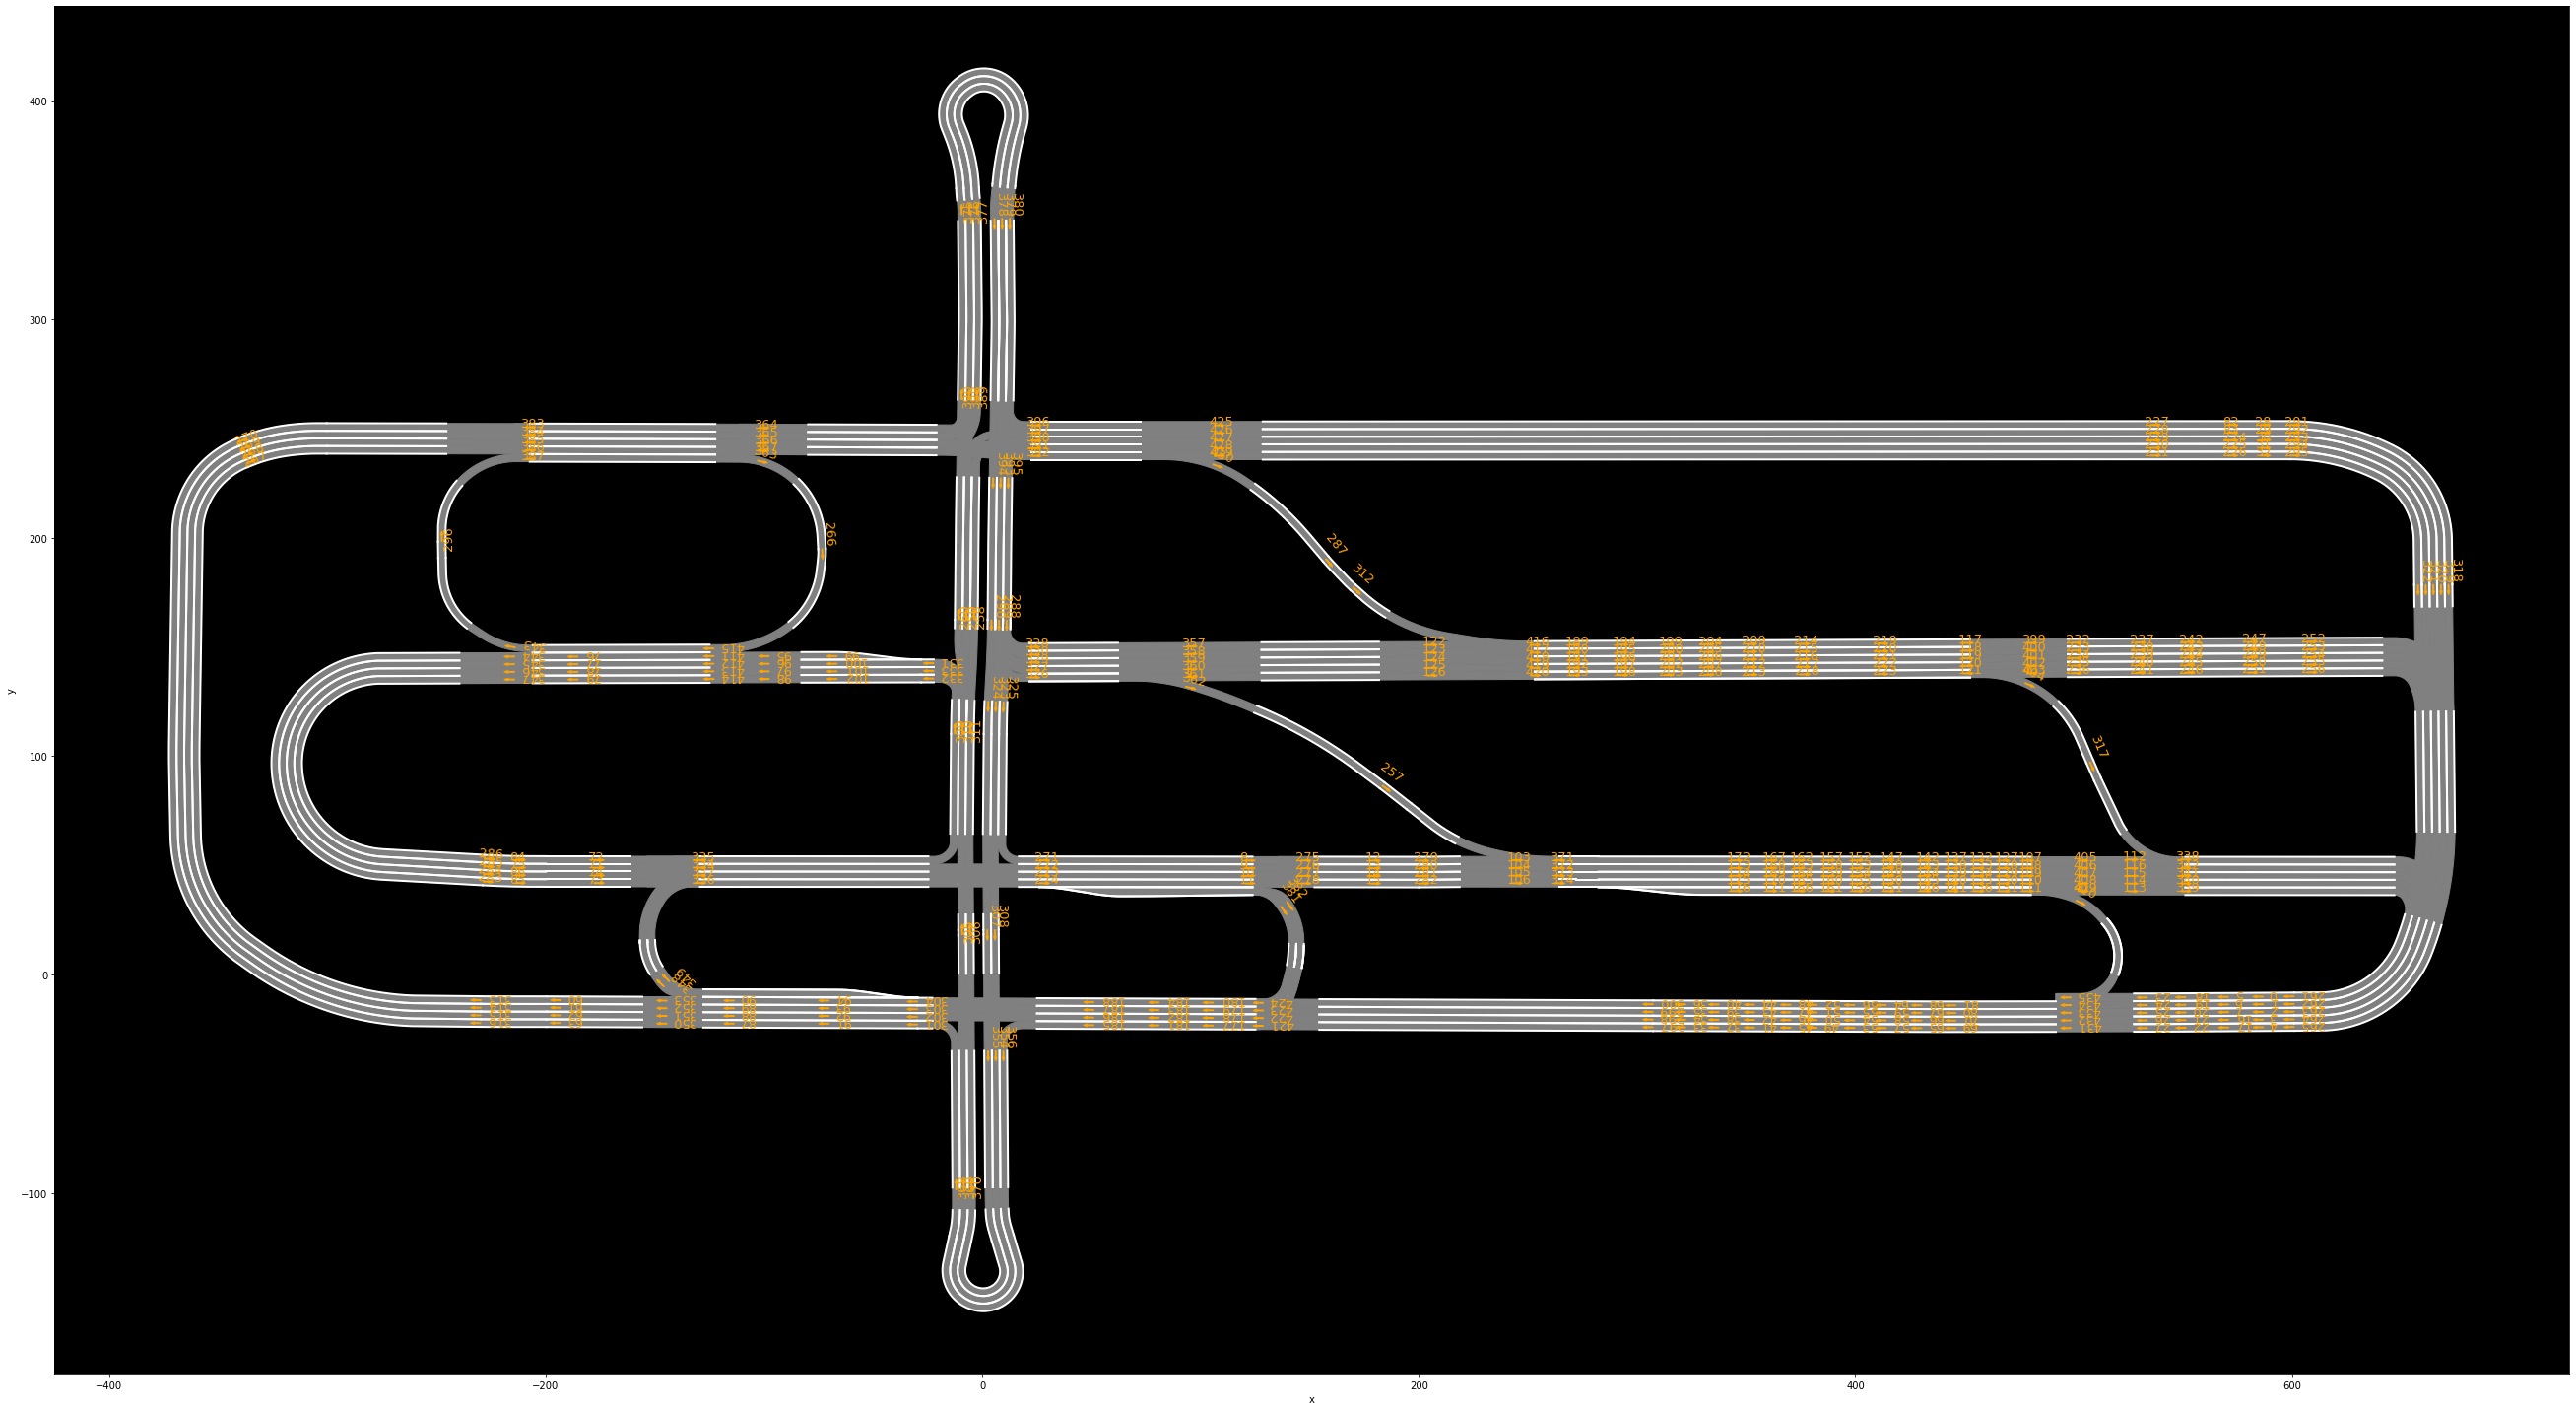

In [7]:
fig, ax = plt.subplots(figsize=(40,20))

for poly in road_polygons:
    patch = matplotlib.patches.Polygon(poly[:, :2], fill=True, color='grey')
    ax.add_patch(patch)
for line in yellow_lines:
    ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
for line in white_lines:
    ax.plot(line.T[0], line.T[1], c='white', linewidth=2)

for idx, sp in enumerate(spawn_points):
    spp = carla.Transform(
            sp.location - 2.5 * sp.get_forward_vector(),
            sp.rotation)
    x, y, _ = carlautil.to_location_ndarray(spp)
    _, yaw, _ = carlautil.to_rotation_ndarray(sp)
    ax.text(x, y, str(idx), color='orange', size=13, rotation=np.rad2deg(yaw))
    x, y, _ = carlautil.to_location_ndarray(sp)
    ax.arrow(x, y, 3*np.cos(yaw), 3*np.sin(yaw), width=0.4, color='orange')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

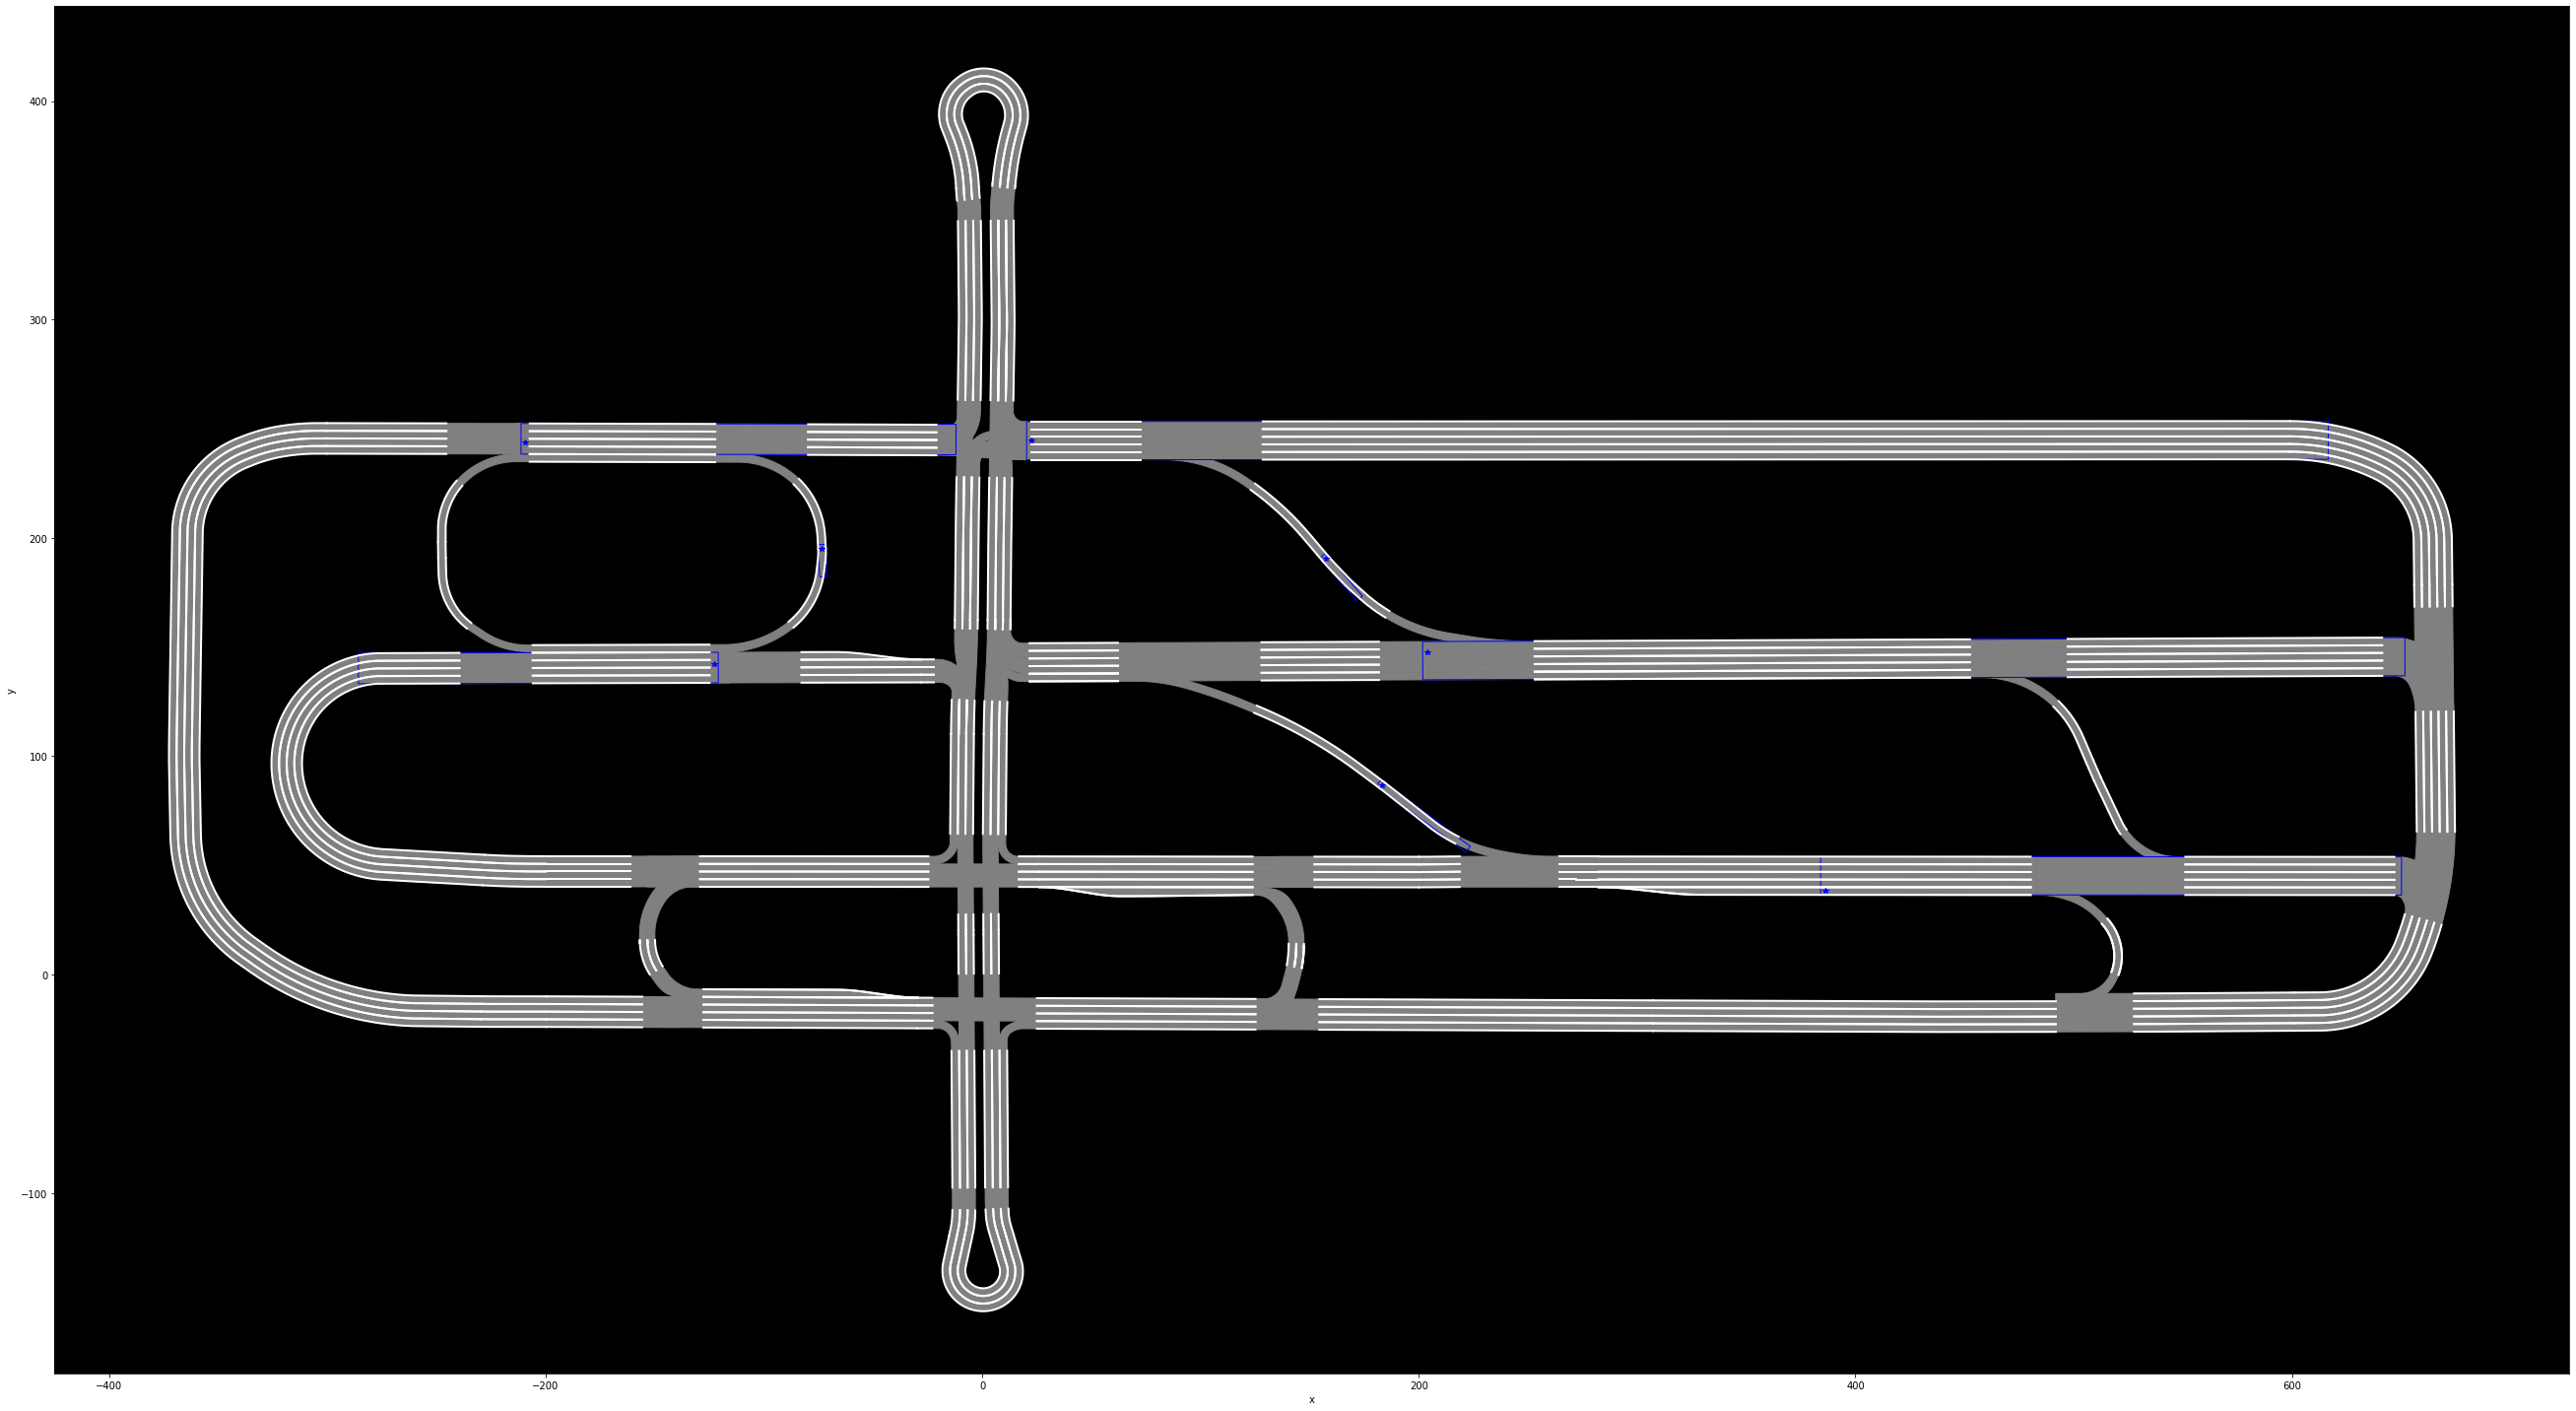

In [15]:
fig, ax = plt.subplots(figsize=(40,20))

for poly in road_polygons:
    patch = matplotlib.patches.Polygon(poly[:, :2], fill=True, color='grey')
    ax.add_patch(patch)
for line in yellow_lines:
    ax.plot(line.T[0], line.T[1], c='yellow', linewidth=2)
for line in white_lines:
    ax.plot(line.T[0], line.T[1], c='white', linewidth=2)

TOL = 2.0
for starting_point in [123, 412, 385, 398, 161, 266, 257, 287]:
    sp = spawn_points[starting_point]
    wp = carla_map.get_waypoint(sp.location)
    ax.plot(sp.location.x, sp.location.y, '*', c='b')
    bbox = get_road_segment_enclosure(wp, tol=TOL)
    patch = patches.Polygon(bbox, ec='b', fc='none')
    ax.add_patch(patch)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_facecolor('black')
fig.tight_layout()

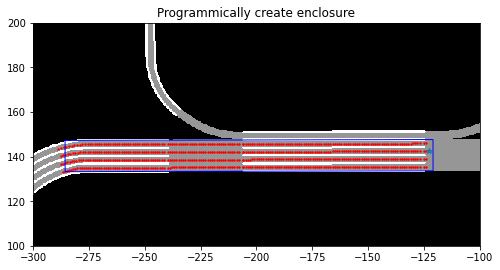

In [10]:
fig, ax = plt.subplots(figsize=(8,8))

x_min  = -300
x_max  = -100
y_min  = 100
y_max  = 200
extent = (x_min, x_max, y_min, y_max)
render_map(ax, extent)

# Programmically create enclosure
TOL=2.0
starting_point = 412
sp = spawn_points[starting_point]
wp = carla_map.get_waypoint(sp.location)
points = get_straight_lanes(wp, tol=TOL)
ax.plot(sp.location.x, sp.location.y, '*')
ax.scatter(points[:,0], points[:,1], c='r', s=2)
bbox = get_road_segment_enclosure(wp, tol=TOL)
patch = patches.Polygon(bbox, ec='b', fc='none')
ax.add_patch(patch)
ax.set_title("Programmically create enclosure")
None